In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import math, time
import itertools
from datetime import datetime
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
import numpy as np
import random
import pandas as pd
import os
import sys
from pylab import mpl, plt
import time
from collections import defaultdict
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import confusion_matrix
from sparsemax import Sparsemax
import functools
import math as ma

from scipy.spatial.distance import hamming
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rl_evt_base_models import MyDataset, lstm, split_data, mlp, tensorize_list_of_tensors, get_factors, mlp_relu_noBatch, mlp_relu_batch
from tqdm import tqdm
import yaml
import argparse
import yfinance as yf
from transformers import get_scheduler
from datasets import load_dataset
from transformers import EncoderDecoderModel, AutoTokenizer, TrainingArguments, Trainer, modeling_outputs
import argparse

from scipy.stats import multivariate_normal

In [12]:
parser = argparse.ArgumentParser(
                prog = 'EVT RL',
                description = 'Representative Learning Model for EVT.')
# args = parser.parse_args()
args = '01_evt_rl_params.yaml'
with open(args, 'r') as f:
# with open(args.filename, 'r') as f:
    params = yaml.safe_load(f)
print("##################################################################################")
print("#################################MODLE PARAMS#####################################")
for key in list(params.keys()):
    print( key, ": ", params[key])
print("##################################################################################")
# Define parameters
num_channels = params["num_channels"]
num_points = params["num_points"]
num_samples = params["num_samples"] #num samples
start_samples = params["start_samples"]
end_samples = params["end_samples"] # Duration 

sigma = params["sigma"]  # noise standard deviation
mean = params["mean"]
output_data = params["output_data"]
plot_base_data = params["plot_base_data"]

hidden_dim_encode = params["hidden_dim_encode"]
output_dim_encode = params["output_dim_encode"]

input_dim_decode = params["input_dim_decode"]
hidden_dim_decode = params["hidden_dim_decode"]
output_dim_decode = params["output_dim_decode"]

num_epochs = params["num_epochs"]
learning_rate = params["learning_rate"]
batchSize = params["batchSize"]
shuffle = params["shuffle"]

rate = params["rate"]
valid_size = params["valid_size"]

##################################################################################
#################################MODLE PARAMS#####################################
num_samples :  100
num_channels :  1
num_points :  1000000
start_samples :  0.1
end_samples :  8
freq :  1
amp :  1
mean :  0
sigma :  0.1
input_dim_encode :  100
hidden_dim_encode :  50
output_dim_encode :  3
input_dim_decode :  3
hidden_dim_decode :  50
output_dim_decode :  100
num_epochs :  800
learning_rate :  0.0001
batchSize :  10000
shuffle :  True
plot_base_data :  True
output_data :  output_data
rate :  0.1
valid_size :  0.5
standard_deviation :  100
##################################################################################


In [13]:
plot_folder = "plots/"
data_folder = "data/"
model_folder = "./model_folder"
num_samples_train = math.floor((1 - valid_size) * num_samples)
model_encode_min = mlp_relu_noBatch(input_dim = num_samples_train, 
                    hidden_dim = hidden_dim_encode, 
                    output_dim = output_dim_encode).to(device)

model_decode_min = mlp_relu_noBatch(input_dim = input_dim_decode, 
                    hidden_dim = hidden_dim_decode, 
                    output_dim = num_samples_train).to(device)

In [18]:
model_encode_min.load_state_dict(torch.load(model_folder + 
                                            "/model_encode_min_bs{}_rt{}_sig{}_ep{}_hd{}.pt".format(batchSize, rate, sigma, num_epochs, output_dim_encode), 
                                            map_location=torch.device('cpu')))
model_decode_min.load_state_dict(torch.load(model_folder + 
                                            "/model_decode_min_bs{}_rt{}_sig{}_ep{}_hd{}.pt".format(batchSize, rate, sigma, num_epochs, output_dim_encode), 
                                            map_location=torch.device('cpu')))



<All keys matched successfully>

In [19]:
file = open(data_folder + "{}_pts{}_mn{}_sg{}.p".format(output_data, num_points, mean, sigma), 'rb')
all_data_df = pickle.load(file)
file.close()

noisy_trig_data = all_data_df['noisy_trig_data'].T
no_noisy_trig_data = all_data_df['no_noisy_trig_data'].T
t = all_data_df['domain'].T
max_data = all_data_df['interval_data']

print("noisy_trig_data.shape: ", noisy_trig_data.shape)

noisy_trig_data.shape:  (1000000, 100, 1)


In [23]:
all_input_data_encode = model_encode_min(torch.tensor(noisy_trig_data[:,:num_samples_train].reshape(-1,num_samples_train)).float().to(device))
random_radial_list = torch.tensor(np.random.exponential(scale = 1 / rate, 
                                                        size = (all_input_data_encode.shape[0])))
A_n = torch.cumsum(random_radial_list, dim=0).view(-1, 1).float().to(device)
all_input_data_encode = all_input_data_encode.to(device) - torch.log(A_n)

#Create random block max sizes
batchSize_factors = get_factors(batchSize) #this function gets common denominators for block sizes
num_batchtes = ma.floor(all_input_data_encode.shape[0] / batchSize)
random_blocksize_list = random.choices(batchSize_factors, k = num_batchtes)

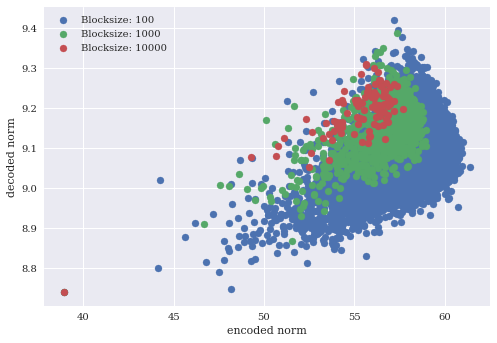

In [73]:
blocksize_list = [100, 1000, 10000]
for blocksize_plot in blocksize_list:
    all_input_data_encode_reshape = all_input_data_encode.reshape(-1, blocksize_plot, input_dim_decode)

    min_values = all_input_data_encode_reshape.max(1)[0]
    out_values_min = model_decode_min(min_values)
    encode_norms = torch.norm(min_values, dim = 1)
    decode_norms = torch.norm(out_values_min, dim = 1)
    plt.scatter(encode_norms.detach().numpy(), decode_norms.detach().numpy(), label = "Blocksize: {}".format(blocksize_plot))
    plt.xlabel("encoded norm")
    plt.ylabel("decoded norm")
plt.legend()
plt.savefig(plot_folder + "blocksize_norm_plot_pts{}_mn{}_sg{}.pdf".format(output_data, num_points, mean, sigma))

In [25]:
data_block_out = {}
for i, blockSize in enumerate(batchSize_factors[1:]):
    
    all_input_data_encode_reshape = all_input_data_encode.reshape(-1, blockSize, input_dim_decode)

    min_values = all_input_data_encode_reshape.max(1)[0]
    out_values_min = model_decode_min(min_values)
    data_block_out[blockSize] = out_values_min

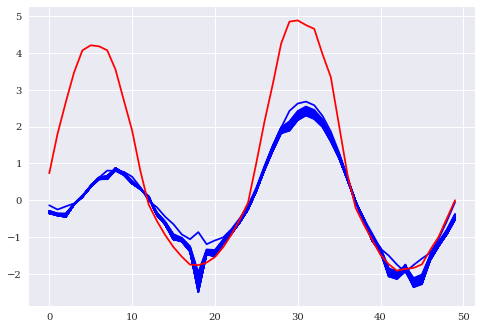

In [82]:
for i in range(data_block_out[10000].shape[0]):
    plt.plot(data_block_out[10000][i].cpu().detach().numpy(), label = "{}".format(i), color = "b", alpha = 1.0)
plt.plot(noisy_trig_data[:,num_samples_train:].reshape(-1,num_samples - num_samples_train).max(0), color = "r")
plt.savefig(plot_folder + "blocksize_var_plot_pts{}_mn{}_sg{}.pdf".format(output_data, num_points, mean, sigma))

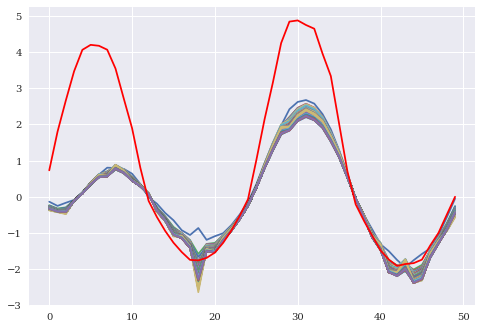

In [42]:
for i in range(data_block_out[1000].shape[0]):
    plt.plot(data_block_out[1000][i].cpu().detach().numpy(), label = "{}".format(i))
plt.plot(noisy_trig_data[:,num_samples_train:].reshape(-1,num_samples - num_samples_train).max(0), color = "r")
plt.show()

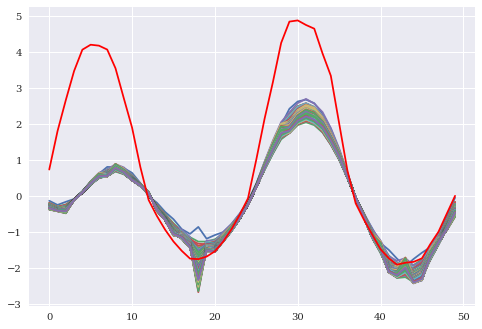

In [43]:
for i in range(data_block_out[100].shape[0]):
    plt.plot(data_block_out[100][i].cpu().detach().numpy(), label = "{}".format(i))
plt.plot(noisy_trig_data[:,num_samples_train:].reshape(-1,num_samples - num_samples_train).max(0), color = "r")
plt.show()
